In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import seaborn as sns
import re
import random
from time import time
from wordcloud import WordCloud
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from __future__ import unicode_literals
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
# import nltk
# nltk.download()
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [3]:
# import csv
lyrics = pd.read_csv('lyrics.csv')

In [4]:
# drop missing data and songs without genre
lyrics = lyrics.dropna()
lyrics = lyrics[lyrics.genre.str.contains("Not Available") == False]
lyrics = lyrics[lyrics.genre.str.contains("Other") == False]

# keep Rock genre only
lyrics = lyrics[lyrics.genre == 'Rock']

# drop unexistent or artists that don't make sense
lyrics = lyrics[lyrics.artist != 'aeena']
lyrics = lyrics[lyrics.artist != 'adaaeaaineay-iaidiia']
lyrics = lyrics[lyrics.artist != 'girls-generation']
lyrics = lyrics[lyrics.artist != 'edaiaoidee']

In [5]:
lyrics.nunique()

index     108700
song       84762
year          48
artist      3761
genre          1
lyrics    102003
dtype: int64

In [6]:
# lowercase everything
lyrics['lyrics'] = lyrics['lyrics'].str.lower()
lyrics['song'] = lyrics['song'].str.lower()
lyrics['artist'] = lyrics['artist'].str.lower()
 
# attempt to drop foreign language songs
searchfor = [' tu ', ' und ', ' ein ', ' dich ', ' amor ', ' ich ', ' auf ', ' bin ', ' dich ', ' du ', ' nicht ', ' el ']
lyrics = lyrics[~lyrics.lyrics.str.contains('|'.join(searchfor))]

In [7]:
# only keep artists with at least 100 songs
lyrics = lyrics.groupby("artist").filter(lambda x: len(x) > 99)

# take a sample of 100 songs from each artist
grouped = lyrics.groupby('artist')
lyrics = grouped.apply(lambda x: x.sample(n=100))

In [8]:
lyrics.nunique()

index     23500
song      21263
year         48
artist      235
genre         1
lyrics    22275
dtype: int64

In [9]:
'''# take a sample of 100 artist
artist_list = lyrics.artist.unique()
artist_list = artist_list[random.sample(range(239), 100)]

# make sure the number of artists is correct
len(artist_list)''';

In [10]:
'''# apply our 100 artist sample to our dataframe
lyrics = lyrics[lyrics['artist'].isin(artist_list)]''';

In [11]:
# combine song name and lyrics
lyrics['lyrics'] = lyrics['lyrics'] + lyrics['song']

# remove all apotrophes
lyrics['lyrics'] = lyrics['lyrics'].str.replace("'", "")

In [12]:
lyrics_original = lyrics
lyrics.head()

index              song  year artist genre  \
artist                                                       
10-cc  238121  238121  headline-hustler  2006  10-cc  Rock   
       238104  238104   old-mister-time  2006  10-cc  Rock   
       238074  238074     for-your-love  2009  10-cc  Rock   
       238144  238144   the-sacro-iliac  2006  10-cc  Rock   
       238086  238086   i-m-not-in-love  1975  10-cc  Rock   

                                                          lyrics  
artist                                                            
10-cc  238121  i got me a job on the local paper\neverybody t...  
       238104  he looked funny\nthe children called him the s...  
       238074  for your love\nfor your love\nid give you ever...  
       238144  heres a new dance that you all can do\nbaby, b...  
       238086  im not in love\nso dont forget it\nits just a ...

In [13]:
# combine all lyrics for each artist
lyrics = lyrics.groupby('artist').lyrics.apply(lambda x: x.sum())

c:\users\todd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'artist' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [14]:
lyrics = lyrics.str.replace('in ', 'ing ')
lyrics = lyrics.str.replace(' ing ', 'in')

In [15]:
# set stemmer
stemmer = SnowballStemmer('english')

# define a function that accepts text and returns a list of lemmas or stems
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize(pos='v') for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
# create and fit our vectorizer
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 1/2 of texts
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case
                             norm=u'l2', # longer paragraphs and shorter paragraphs treated equally
                             smooth_idf=True, # add 1 to all document frequencies
                             max_features=65, # limit to top 55 words
                             analyzer=lambda x:word_tokenize(x, how='lemma')
                        )
vect = tfidf.fit_transform(lyrics)

In [16]:
# preserve column names
vocab = tfidf.vocabulary_
tfidf = tfidf.transform(lyrics)

# be sure keys are sorted
tfidf = pd.DataFrame(tfidf.toarray(), columns=sorted(vocab.keys()))

In [17]:
# see our result
tfidf.head()

,2,american,ass,bang,battle,bitch,bow,brown,bye,c,...,sunshine,t,uh,wa,whoa,wo,wonderful,yea,yo,york
0,0.0000,0.418814,0.083763,0.055188,0.000000,0.081824,0.023811,0.000000,0.000000,0.000000,...,0.139278,0.000000,0.000000,0.0,0.000000,0.0,0.025364,0.248595,0.000000,0.000000
1,0.0227,0.013104,0.104835,0.025902,0.055308,0.089607,0.000000,0.022011,0.000000,0.039020,...,0.021789,0.012441,0.206838,0.0,0.695420,0.0,0.000000,0.014584,0.285921,0.034588
2,0.0000,0.031216,0.031216,0.061700,0.039524,0.060986,0.000000,0.000000,0.046006,0.000000,...,0.012976,0.000000,0.028983,0.0,0.041414,0.0,0.000000,0.052112,0.000000,0.000000
3,0.0000,0.000000,0.103243,0.034011,0.116199,0.403410,0.029348,0.000000,0.033813,0.000000,...,0.000000,0.130688,0.031952,0.0,0.000000,0.0,0.187575,0.000000,0.000000,0.000000
4,0.0000,0.000000,0.000000,0.029547,0.000000,0.116819,0.025496,0.050217,0.000000,0.089021,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.380224,0.099821,0.362398,0.026304


In [18]:
# create extra feature, length
length = (lyrics_original.groupby('artist')['lyrics']
                            .apply(lambda x: np.mean(x.str.len()))
                            .reset_index(name='mean_len_text'))
tfidf = tfidf.join(length)

c:\users\todd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'artist' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [19]:
# store for cluster
cluster = tfidf.drop(columns='artist')

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(cluster)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(cluster)

In [20]:
# join our cluster number to each row/artist
predict_mini = pd.DataFrame(predict_mini, columns=['cluster'])
tfidf = tfidf.join(predict_mini)

In [21]:
# drop nonsense columns
tfidf.drop(columns = ['2', 'c', 'd', 'e', 'g', 'm', 'n', 'o', 's', 't'], inplace=True)

# fix name
tfidf = tfidf.rename(columns = {'mountaing':'mountain'})

In [22]:
tfidf.nunique()

american          82
ass               82
bang              84
battle           113
bitch             86
bow              111
brown            114
bye               85
christmas        103
cmon              72
company          118
da                63
de                60
di                20
doo               36
drug             102
drum             114
dumb              89
fuck             114
ga                13
gim               74
gods             103
ha                79
ho                69
hurry            112
kimi               4
kinda            111
mercy            110
mo                20
mom               82
mr               112
ni                 6
ok               113
outta             91
praise            77
rhythm           108
santa             48
saturday          94
sex               97
shit             112
soldier          101
souls            114
stronger         116
stupid           105
suck             100
suffer           109
sunshine         116
uh           

In [23]:
cluster = tfidf.groupby('cluster').mean()

In [24]:
word_list = list(cluster.columns.values)

In [25]:
one_list = tfidf.artist[tfidf.cluster == 0]
two_list = tfidf.artist[tfidf.cluster == 1]
three_list = tfidf.artist[tfidf.cluster == 2]
four_list = tfidf.artist[tfidf.cluster == 3]
five_list = tfidf.artist[tfidf.cluster == 4]
six_list = tfidf.artist[tfidf.cluster == 5]
seven_list = tfidf.artist[tfidf.cluster == 6]
eight_list = tfidf.artist[tfidf.cluster == 7]
nine_list = tfidf.artist[tfidf.cluster == 8]
ten_list = tfidf.artist[tfidf.cluster == 9]

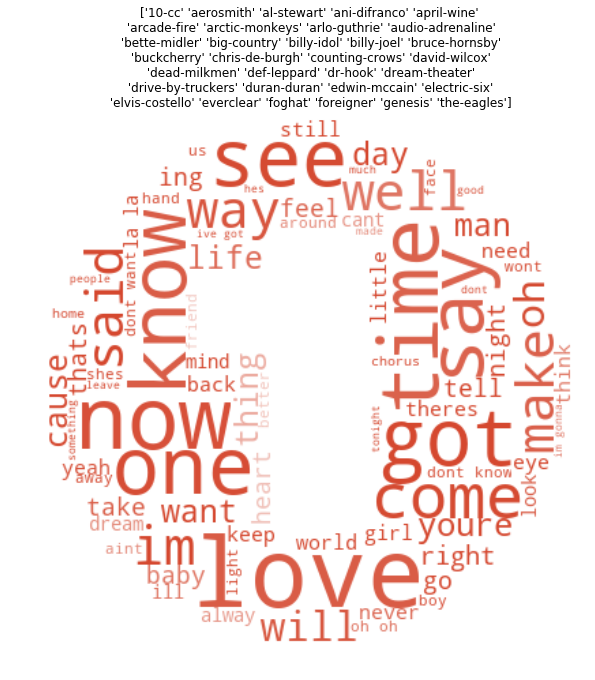

<Figure size 432x288 with 0 Axes>

In [59]:
d = path.dirname('__file__')
mask = np.array(Image.open(path.join(d, "one.png")))
image_colors = ImageColorGenerator(mask)

one = lyrics[lyrics.index.isin(one_list)]

one = one.sum()

# world cloud parameters and generation
first = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
first.generate(one)

# show
plt.figure(figsize=(12,10))
plt.title(one_list.unique(), fontsize=12)
plt.imshow(first.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

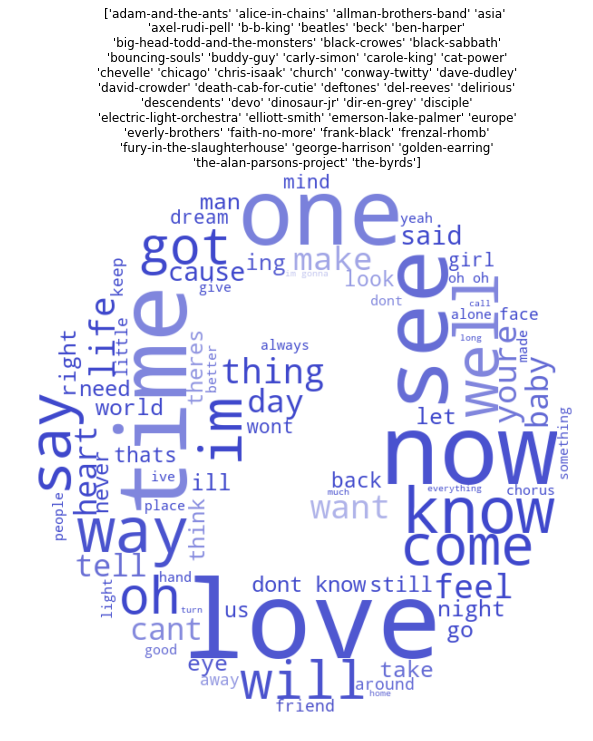

<Figure size 432x288 with 0 Axes>

In [37]:
mask = np.array(Image.open(path.join(d, "two.png")))
image_colors = ImageColorGenerator(mask)

two = lyrics[lyrics.index.isin(two_list)]

two = two.sum()

# world cloud parameters and generation
second = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
second.generate(two)

# show
plt.figure(figsize=(12,10))
plt.title(two_list.unique(), fontsize=12)
plt.imshow(second.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

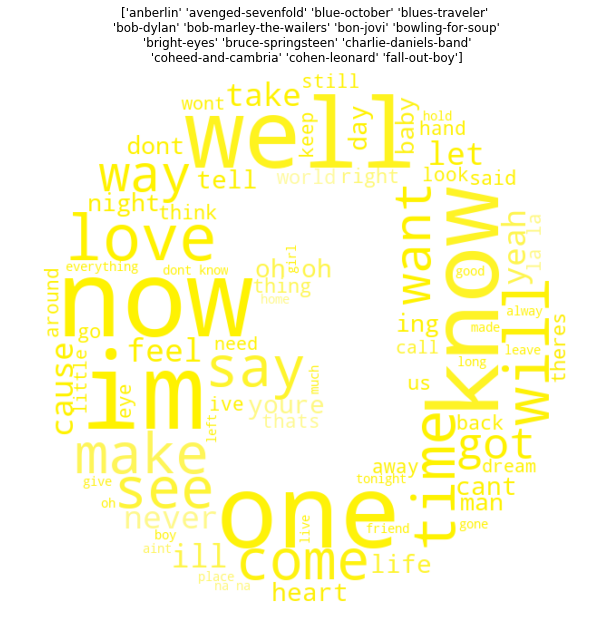

<Figure size 432x288 with 0 Axes>

In [38]:
mask = np.array(Image.open(path.join(d, "three.png")))
image_colors = ImageColorGenerator(mask)

three = lyrics[lyrics.index.isin(three_list)]

three = three.sum()

# world cloud parameters and generation
third = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
third.generate(three)

# show
plt.figure(figsize=(12,10))
plt.title(three_list.unique(), fontsize=12)
plt.imshow(third.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

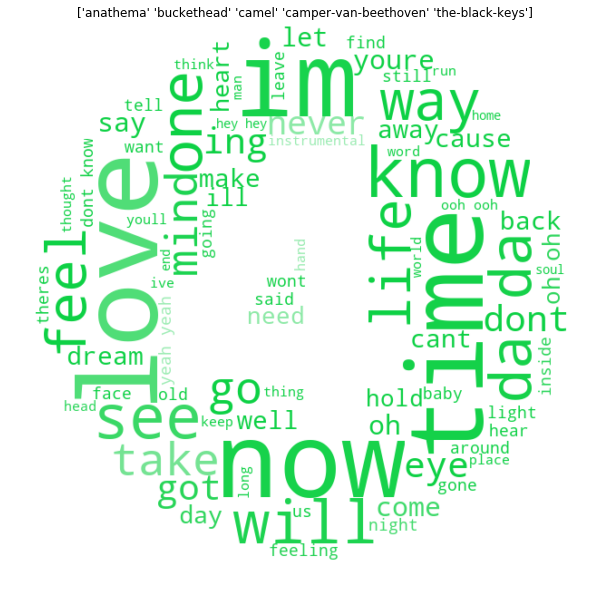

<Figure size 432x288 with 0 Axes>

In [39]:
mask = np.array(Image.open(path.join(d, "four.png")))
image_colors = ImageColorGenerator(mask)

four = lyrics[lyrics.index.isin(four_list)]

four = four.sum()

# world cloud parameters and generation
fourth = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
fourth.generate(four)

# show
plt.figure(figsize=(12,10))
plt.title(four_list.unique(), fontsize=12)
plt.imshow(fourth.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

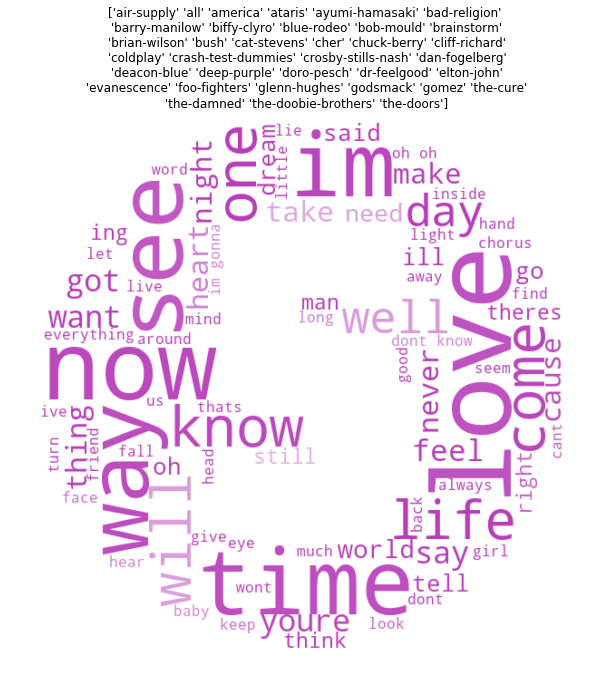

<Figure size 432x288 with 0 Axes>

In [41]:
mask = np.array(Image.open(path.join(d, "five.png")))
image_colors = ImageColorGenerator(mask)

five = lyrics[lyrics.index.isin(five_list)]

five = five.sum()

# world cloud parameters and generation
fifth = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
fifth.generate(five)

# show
plt.figure(figsize=(12,10))
plt.title(five_list.unique(), fontsize=12)
plt.imshow(fifth.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

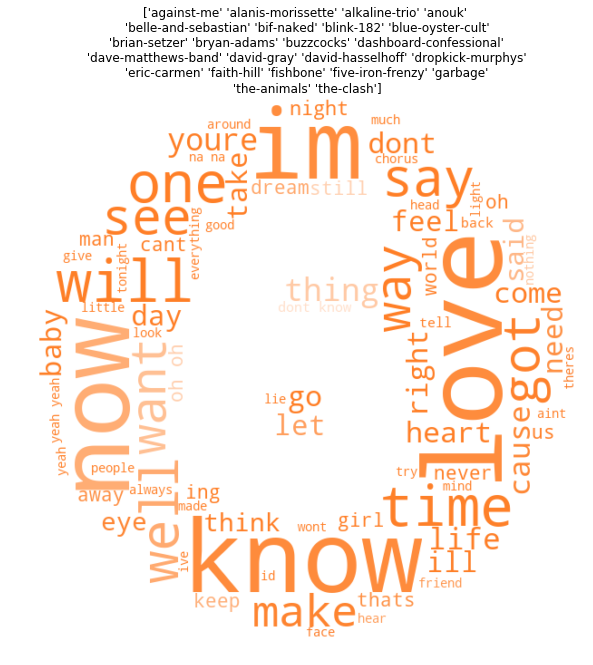

<Figure size 432x288 with 0 Axes>

In [43]:
mask = np.array(Image.open(path.join(d, "six.png")))
image_colors = ImageColorGenerator(mask)

six = lyrics[lyrics.index.isin(six_list)]

six = six.sum()

# world cloud parameters and generation
sixth = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
sixth.generate(six)

# show
plt.figure(figsize=(12,10))
plt.title(six_list.unique(), fontsize=12)
plt.imshow(sixth.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

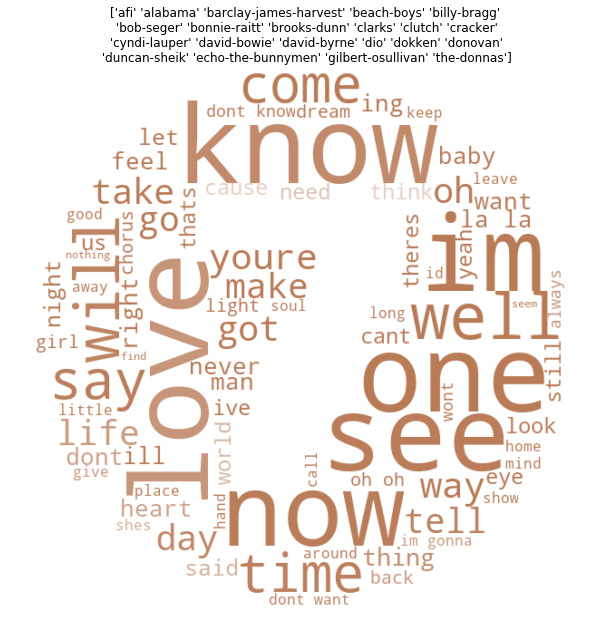

<Figure size 432x288 with 0 Axes>

In [44]:
mask = np.array(Image.open(path.join(d, "seven.png")))
image_colors = ImageColorGenerator(mask)

seven = lyrics[lyrics.index.isin(seven_list)]

seven = seven.sum()

# world cloud parameters and generation
seventh = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
seventh.generate(seven)

# show
plt.figure(figsize=(12,10))
plt.title(seven_list.unique(), fontsize=12)
plt.imshow(seventh.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

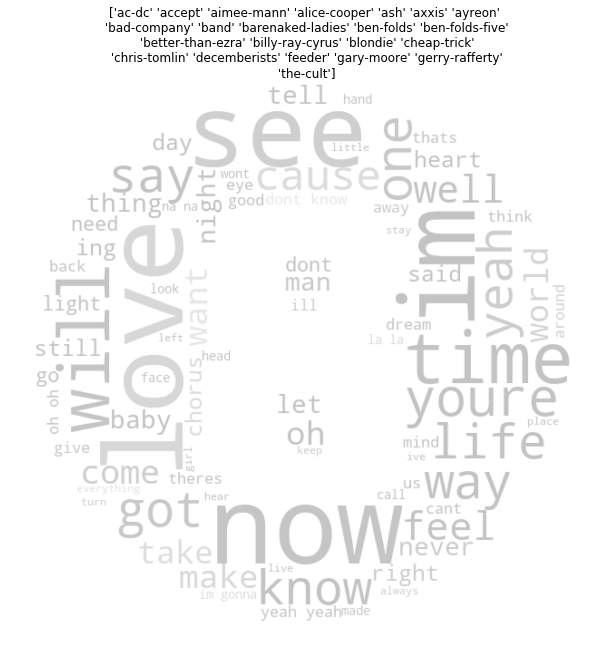

<Figure size 432x288 with 0 Axes>

In [51]:
mask = np.array(Image.open(path.join(d, "eight.png")))
image_colors = ImageColorGenerator(mask)

eight = lyrics[lyrics.index.isin(eight_list)]

eight = eight.sum()

# world cloud parameters and generation
eighth = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
eighth.generate(eight)

# show
plt.figure(figsize=(12,10))
plt.title(eight_list.unique(), fontsize=12)
plt.imshow(eighth.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

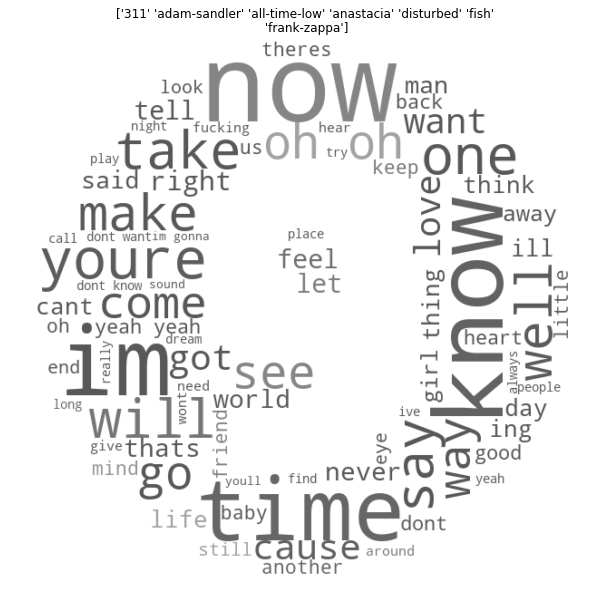

<Figure size 432x288 with 0 Axes>

In [54]:
mask = np.array(Image.open(path.join(d, "nine.png")))
image_colors = ImageColorGenerator(mask)

nine = lyrics[lyrics.index.isin(nine_list)]

nine = nine.sum()

# world cloud parameters and generation
nineth = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
nineth.generate(nine)

# show
plt.figure(figsize=(12,10))
plt.title(nine_list.unique(), fontsize=12)
plt.imshow(nineth.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

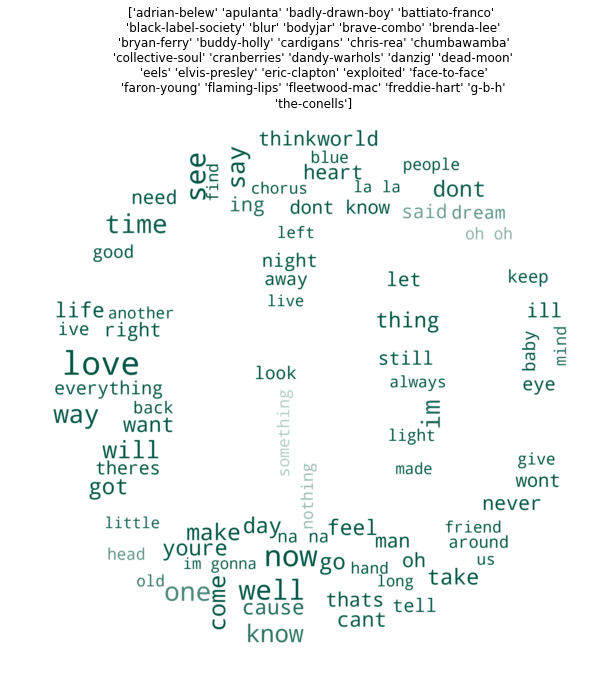

<Figure size 432x288 with 0 Axes>

In [58]:
mask = np.array(Image.open(path.join(d, "ten.png")))
image_colors = ImageColorGenerator(mask)

ten = lyrics[lyrics.index.isin(ten_list)]

ten = ten.sum()

# world cloud parameters and generation
tenth = WordCloud(background_color="white", width=800, height=800, max_words=80, mask=mask, max_font_size=120, random_state=50)
tenth.generate(ten)

# show
plt.figure(figsize=(12,10))
plt.title(ten_list.unique(), fontsize=12)
plt.imshow(tenth.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()